In [1]:
# Based on https://www.pyimagesearch.com/2016/08/01/lenet-convolutional-neural-network-in-python/

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def show(cv_image):
    img = cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize = (20,10))
    plt.imshow(img, interpolation='nearest')
    plt.axis('off')
    plt.show()
    
def showGrey(img):
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

In [3]:
# imports 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Dropout, Flatten, Dense
from keras.optimizers import SGD, Adadelta
from keras.losses import categorical_crossentropy
from keras.utils import np_utils
from imutils import paths
import numpy as np
import cv2
import os

Using TensorFlow backend.


In [4]:
# load data set

def image_to_feature_vector(image, size=(28, 28)):
    return cv2.resize(image, size)

def rotate(image, angle=90):
    rows = image.shape[0]
    cols = image.shape[1]
    M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
    return cv2.warpAffine(image,M,(cols,rows))
    
dataset_dir = "/Users/rokickik/Downloads/Workstation/orientation/20x/left"
imagePaths = list(paths.list_images(dataset_dir))

raw_data = []
raw_labels = []
for (i, imagePath) in enumerate(imagePaths):
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    raw_data.append(image_to_feature_vector(image))
    raw_labels.append("left")

    right = rotate(image, angle=-90)
    raw_data.append(image_to_feature_vector(image))
    raw_labels.append("right")
        
print("Loaded %d images" % len(raw_labels))

Loaded 1392 images


In [5]:
# encode the labels, converting them from strings to integers
le = LabelEncoder()
labels = le.fit_transform(raw_labels)

# scale the input image pixels to the range [0, 1], then transform
# the labels into vectors in the range [0, num_classes] -- this
# generates a vector for each label where the index of the label
# is set to `1` and all other entries to `0`
data = np.array(raw_data) / 255.0
data = data[:, :, :, np.newaxis]
labels = np_utils.to_categorical(labels, 2)
 
# partition the data into training and testing splits, using 75%
# of the data for training and the remaining 25% for testing
(trainData, testData, trainLabels, testLabels) = train_test_split(
    data, labels, test_size=0.25, random_state=42)
    
print("Train data shape: "+ str(trainData.shape))
print("Test data shape: "+ str(testData.shape))

Train data shape: (1044, 28, 28, 1)
Test data shape: (348, 28, 28, 1)


In [6]:
# network architectures 

class LeNet:
    @staticmethod
    def build(input_shape, classes, weightsPath=None):
        model = Sequential()
        model.add(Conv2D(20, (5, 5), activation='relu', padding="same", input_shape=input_shape))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(Conv2D(50, (5, 5), activation='relu', padding="same"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(Flatten())
        model.add(Dense(500, activation='relu'))
        model.add(Dense(classes, activation='softmax'))

        if weightsPath is not None:
            model.load_weights(weightsPath)
 
        return model
        
class LeNet2:
    @staticmethod
    def build(input_shape, classes, weightsPath=None):
        model = Sequential()
        model.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=input_shape))
        model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))

        model.add(Dense(classes, activation='softmax'))

        if weightsPath is not None:
            model.load_weights(weightsPath)
 
        return model
    
class LeNet3:
    @staticmethod
    def build(input_shape, classes, weightsPath=None):
        model = Sequential()
        print(input_shape)
        model.add(Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(classes, activation='softmax'))

        if weightsPath is not None:
            model.load_weights(weightsPath)
 
        return model
    

In [7]:
# define the model
verbose=1
epochs=50
batch_size=128
opt = SGD(lr=0.01)
#opt = Adadelta()
model = LeNet3.build((28,28,1), classes=2, weightsPath=None)
print(model.summary())

(28, 28, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0        

In [8]:
# train
model.compile(loss=categorical_crossentropy, optimizer=opt, metrics=["accuracy"])
model.fit(trainData, trainLabels, batch_size=batch_size, epochs=epochs, verbose=verbose)
(loss, accuracy) = model.evaluate(testData, testLabels, batch_size=batch_size, verbose=verbose)
print("Test set loss: {:.4f}, accuracy: {:.2f}%".format(loss, accuracy * 100))

# save weights to disk
model_filepath = "/Users/rokickik/Downloads/Workstation/orientation/lenet.weights"
model.save(model_filepath, overwrite=True)

Epoch 1/50
1044/1044 [==============================] - 3s 3ms/step - loss: 0.6962 - acc: 0.4952
Epoch 2/50
1044/1044 [==============================] - 3s 3ms/step - loss: 0.6956 - acc: 0.4761
Epoch 3/50
1044/1044 [==============================] - 3s 3ms/step - loss: 0.6971 - acc: 0.4818
Epoch 4/50
1044/1044 [==============================] - 3s 2ms/step - loss: 0.6959 - acc: 0.4713
Epoch 5/50
1044/1044 [==============================] - 3s 2ms/step - loss: 0.6950 - acc: 0.4933
Epoch 6/50
1044/1044 [==============================] - 3s 3ms/step - loss: 0.6943 - acc: 0.5201
Epoch 7/50
1044/1044 [==============================] - 3s 3ms/step - loss: 0.6944 - acc: 0.4847
Epoch 8/50
1044/1044 [==============================] - 3s 3ms/step - loss: 0.6903 - acc: 0.5220
Epoch 9/50
1044/1044 [==============================] - 3s 3ms/step - loss: 0.6969 - acc: 0.4808
Epoch 10/50
1044/1044 [==============================] - 3s 3ms/step - loss: 0.6953 - acc: 0.4904
Epoch 11/50
1044/1044 [======

loading model
Classifying JRC_IS04526-20150904_41_C3.png


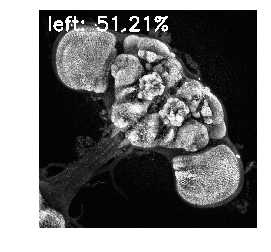

Classifying JRC_IS04527-20150904_41_C2.png


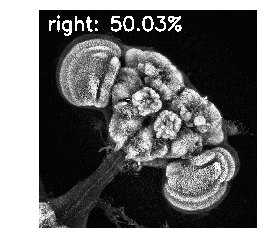

Classifying JRC_IS05101-20150904_44_C1.png


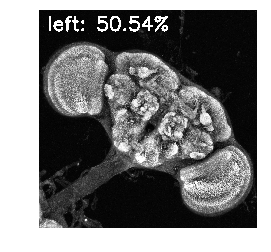

Classifying JRC_IS05110-20150904_44_B3.png


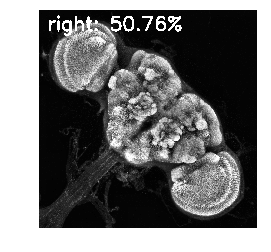

Classifying JRC_IS05113-20150904_44_H1.png


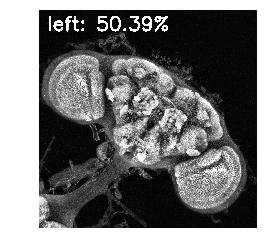

Classifying JRC_IS05117-20150904_44_H5.png


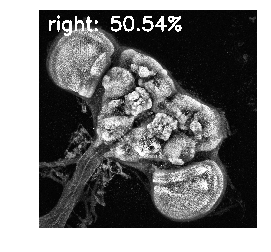

Classifying JRC_IS05123-20150904_44_H4.png


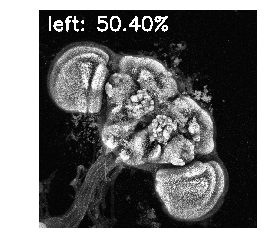

Classifying JRC_IS05128-20150904_44_C3.png


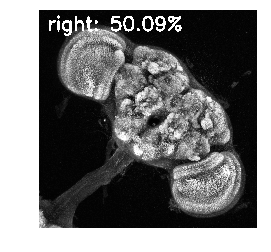

Classifying JRC_SS16571-20180411_35_A2.png


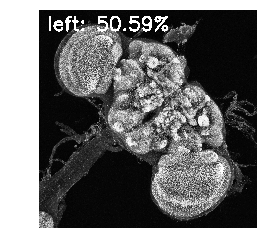

Classifying JRC_SS16571-20180411_35_A3.png


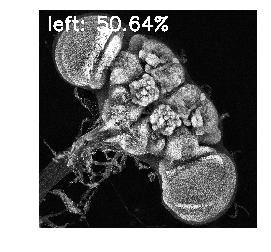

Classifying JRC_SS16571-20180411_35_A6.png


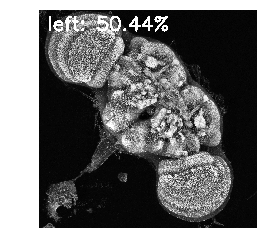

Classifying JRC_SS16571-20180411_35_B2.png


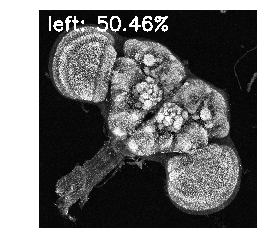

Classifying JRC_SS16571-20180411_35_B5.png


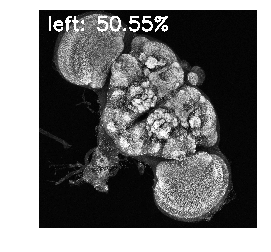

Classifying JRC_SS16571-20180411_35_B6.png


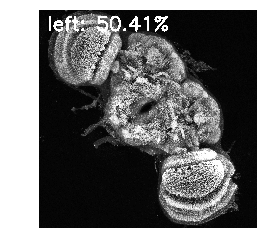

In [9]:
# test on actual right-oriented data

from keras.models import load_model

test_dir = "/Users/rokickik/Downloads/Workstation/orientation/20x/right"

# initialize the class labels 
CLASSES = ["left", "right"]
 
# load the network
print("loading model")
model = load_model(model_filepath)

# loop over our testing images
for imagePath in paths.list_images(test_dir):
    # load the image, resize it to a fixed 32 x 32 pixels (ignoring
    # aspect ratio), and then extract features from it
    print("Classifying {}".format(imagePath[imagePath.rfind("/") + 1:]))
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    features = image_to_feature_vector(image) / 255.0
    features = features[np.newaxis, :, :, np.newaxis]
    
    probs = model.predict(features)[0]
    prediction = probs.argmax(axis=0)

    # draw the class and probability on the test image and display it
    label = "{}: {:.2f}%".format(CLASSES[prediction], probs[prediction] * 100)
    cv2.putText(image, label, (40, 95), cv2.FONT_HERSHEY_SIMPLEX, 3.0, (255, 255, 255), 10)
    showGrey(image)


In [ ]:
# Not yet working

from sklearn.grid_search import GridSearchCV, RandomizedSearchCV

# construct the set of hyperparameters to tune
#params = {"n_neighbors": np.arange(1, 31, 2),
#          "metric": ["euclidean", "cityblock"]}

#grid = GridSearchCV(model, params)
grid = RandomizedSearchCV(model, params)
start = time.time()
grid.fit(trainData, trainLabels)
print("Grid search took {:.2f} seconds".format(time.time() - start))
acc = grid.score(testData, testLabels)
print("Grid search accuracy: {:.2f}%".format(acc * 100))
print("Grid search best parameters: {}".format(grid.best_params_))

